## IGNORE
This is just extra colab level code

In [ ]:
!pip install langdetect

In [ ]:
%cd drive/My\ Drive/moviereviews

[Errno 2] No such file or directory: 'drive/My Drive/moviereviews'
/content/drive/My Drive/moviereviews


# Data Cleaning for MovieSentiments

This is the main notebook for the data preprocessing and cleaning steps we took for the MovieSentiments web app. We will try to document the journey and the steps we took for this project. If you find any questions feel free to contact us!

## Imports

In [ ]:
import pandas as pd
import string
import re
import spacy
import langdetect
import numpy as np
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [ ]:
df = pd.read_csv(
    "movie_reviews.csv", 
    index_col=0, 
    dtype={"Review Score": np.float16}
    )
df.columns = ["title", "text", "score"]

## Exploratory Data Analysis
We will start off by a basic overview via EDA.

#### First Steps
From very introductory steps, we can observe the type of data we're dealing with. We can see the total number of samples we have is 9823, with 3 columns. It will be very interesting to see what this shape turns into by the end 👀.

In [ ]:
print(df.dtypes)
print(df.shape)

title     object
text      object
score    float16
dtype: object
(9826, 3)


In [ ]:
df.head()

,title,text,score
0,Parasite (Gisaengchung),Outstanding! Delightfully clever movie all th...,5.0
1,Parasite (Gisaengchung),Parasite seduces us with such a subtle suggest...,5.0
2,Parasite (Gisaengchung),"Predictable, unbelievable, a film that's unawa...",0.5
3,Parasite (Gisaengchung),Parasite should have been shortened before its...,3.5
4,Parasite (Gisaengchung),listen- i liked it. it was a rlly rad film. bu...,5.0


In [ ]:
#@markdown ##### A sample string from the dataframe:
df['text'].sample(1).item()

'Bleak but top acting'

Fortunately, we don't have any empty fields for the title and review text , this is largely because we scraped this data from a website where validation of the fields is required, so we got fairly lucky.

In [ ]:
print("Empty values for movie title:", df['title'].eq('').sum())
print("Empty values for review text:", df['text'].eq('').sum())

Empty values for movie title: 0
Empty values for review text: 0


In [ ]:
df.describe()

,score
count,9826.000000
mean,3.755859
std,1.199219
min,0.500000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


#### Visualizations

##### Review Score Distribution

While we could get a similar grasp from the raw numbers listed by describe(), this visualization can give us a more human-friendly understanding of the classses we're dealing with

In [ ]:
px.histogram(df, 
             x="score",
             labels={"count": "Count", "score": "Review Score"},
             title = "Distribution of Review Scores",
             ).show()

We can see that we are dealing with data that has unbalanced classes, due to the far higher prominence of ratings between 3 and 5,  vs. 0 to 2.5.

##### Review Word Distribution

Simply to highlight the importance of stopword removal, this is a log of the most common words from the review text, as observed, there are a lot of occurences of words with practically no meaning.

In [ ]:
counts = Counter(" ".join(df["text"]).split()).most_common(10)
for word, count in counts:
    print(f"'{word}' has {count} occurrences.")

'the' has 28018 occurrences.
'and' has 19123 occurrences.
'a' has 17191 occurrences.
'of' has 15809 occurrences.
'to' has 13096 occurrences.
'is' has 10783 occurrences.
'in' has 8300 occurrences.
'I' has 6766 occurrences.
'that' has 6626 occurrences.
'it' has 5968 occurrences.


In [ ]:
def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
        ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

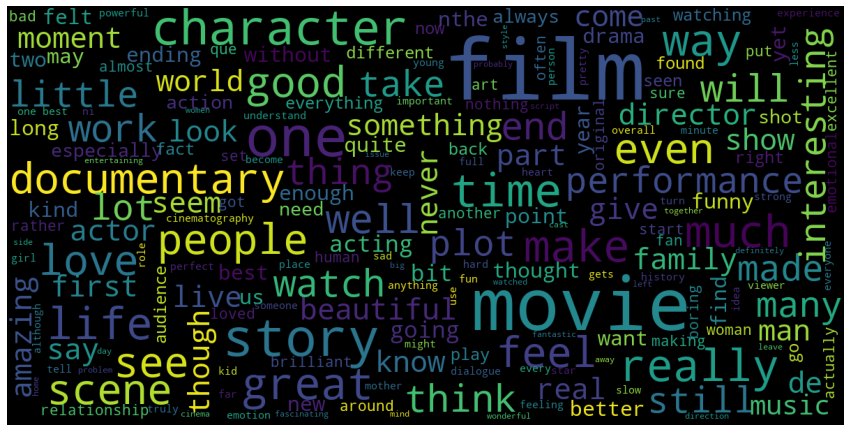

In [ ]:
#@markdown From a simple wordcloud with major stop words filtered out, it is 
#@markdown noticeable that the more frequent words are far more meaningful.
show_wordcloud(df['text'].str.lower().to_list())

##### Review Length Distribution

In [ ]:
review_lengths = df['text'].str.split().str.len()
px.strip(
    df, 
    "score", 
    review_lengths, 
    labels={"score": "Movie Rating", "y": "Length of Review"},
    title="Length of Review vs Movie Rating"
    ).show()

##### Average Length Grouped By Rating Given

In [ ]:
def mean_len_per_rating(df, review_lengths):
    df['review_lengths'] = review_lengths
    score_vs_length = df.groupby('score', as_index=False).mean()
    df.drop(columns='review_lengths', inplace=True)
    return score_vs_length

In [ ]:
len_vs_score = mean_len_per_rating(df, review_lengths)
fig = px.bar(
    len_vs_score, 
    x="score", 
    y="review_lengths", 
    labels={
        "review_lengths": "Average Length of Reviews", 
        "score": "Review Score"
        },
    range_x=[0, 5.5],
    title="Average Length of Reviews by Rating"
    )
fig.update_layout(
    shapes=[
            {
                "type": "line",  
             "line": {"color": "lightpink"},  
             "name": "Average of all Reviews' Lengths",        
             "yref": "y",
             "y0": review_lengths.mean(), 
             "y1": review_lengths.mean(), 
             "xref": "paper", 
             "x0": 0, 
             "x1": 1
             }
            ]
            );

The following figure displays the average length of reviews by rating given, with the pink line showing the overall average of rating length. It seems that ratings between 2-4 stars carry the most amount of content. It will be interesting to observe if this correlates to the keyword information that can be extracted.

In [ ]:
fig

## Data Cleaning
This section will include the actual manipulation and cleaning of the data.

#### Removing Non-English Reviews

As this data was collected from a source that contained movies and reviews from various languages, we must remove the data that doesn't include english samples.

##### spaCy.io 
We were initially planning on using spaCy.io to detect non-english text, however the inferences were taking too long for the entire dataframe so we moved onto Google's lang-detect library. These cells can be ignored, but it includes testing for our spacy implementation.

In [ ]:
!pip install spacy-langdetect
!pip install langdetect

In [ ]:
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
text = "This is English text. Er lebt mit seinen Eltern und seiner Schwester in Berlin. Yo me divierto todos los días en el parque. Je m'appelle Angélica Summer, j'ai 12 ans et je suis canadienne."
doc = nlp(text)
print(doc._.language)

{'language': 'de', 'score': 0.5714272425537468}


In [ ]:
nlp = spacy.load("en")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
def spacy_is_english(text):
    return nlp(text)._.language == "en"

###### Speed Testing

If you want to see the difference in running times for spacy vs langdetect feel free to unhide the below cells. Else, they can be ignored.

In [ ]:
test_sample = df['text'].sample(200)
print("spaCy lang-detect: ")
%timeit test_sample.apply(spacy_is_english)
print("regular lang-detect: ")
%timeit test_sample.apply(is_english)

spaCy lang-detect: 
1 loop, best of 3: 3.72 s per loop
regular lang-detect: 
1 loop, best of 3: 750 ms per loop


##### langdetect

In [ ]:
print("1): ", langdetect.detect_langs("This is an english text. Et c'est en français"))
print("2): ", langdetect.detect("This is for the main language in the text."))

1):  [fr:0.5714281289832885, en:0.42857164049399926]
2):  en


In [ ]:
def is_english(text):
    try:
        return langdetect.detect(text) == "en"
    except langdetect.lang_detect_exception.LangDetectException:
        return False

##### langdetect -- continued

In [ ]:
english_text = df['text'].progress_apply(is_english)

In [ ]:
print(f"Original length of data: {len(df)}")
print(f"Length of data with only english: {len(df[english_text])}")

Original length of data: 9826
Length of data with only english: 9225


In [ ]:
df[~english_text].sample(15)

,title,text,score
641,Homecoming: A Film by Beyoncé,"impressionante, maravilhoso, lindo, beyoncé se...",5.0
17,Avengers: Endgame,No just no just no just no,1.5
8185,Senna,FantÃ¡stico para lembrar bons tempos do Ã­dolo...,4.0
4976,Leviathan,"Très bon film, un peu dur à la fin tout de mêm...",4.0
7977,Source Code,"Originale film con budget ridotto, frenetico e...",4.0
2200,Guardians of the Galaxy Vol. 2,Los chistes y/o chascarrillos usados en la pel...,2.0
5947,Inside Llewyn Davis,06.05.2020 ---------,3.5
6488,Caesar Must Die,Mesclando a ficção com o documentário (o que o...,5.0
5427,Housebound,Porque filme ruim eh bom pra caralho,5.0
7226,Safety Not Guaranteed,Muy buena y lo mejor es que se puede ver en Yo...,5.0


As noticed, `langdetect` didn't classify english text with 100% accuracy, however, it is good enough for our purposes. From extracting non-english text, we lost ~600 samples.

In [ ]:
df = df[english_text] # RUN THIS
df.reset_index(drop=True, inplace=True)
df.sample(5)

,title,text,score
924,A Quiet Place,Great idea for horror story. Any critic out th...,5.0
5662,56 Up,Holy shit! Grandchildren the age they were whe...,5.0
4975,How to Train Your Dragon 2,The Most Epic Animated Movie!The music was phe...,5.0
6733,Wake in Fright,One of my favorite all-time horror movies. At ...,5.0
1078,Sorry to Bother You,"F—-king stupid, Kept hoping it would get bette...",0.5


##### URL Extraction

In [ ]:
a = pd.DataFrame(
    {
        "text": [
                 "This text https://scikit-learn.org/ contains 2 urls, this "
                  "is the next one https://www.google.ca/?client=safari"
                 ]
     }
    )
print("String before extraction:")
print(a['text'].item())
print(f"After:")
print(a['text'].str.replace(r'https?://\S+|www\.\S+', "").item())

String before extraction:
This text https://scikit-learn.org/ contains 2 urls, this is the next one https://www.google.ca/?client=safari
After:
This text  contains 2 urls, this is the next one 


In [ ]:
df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', "")

##### HTML Extraction

In [ ]:
a = pd.DataFrame(
    {
        "text": [
                 """
                 <meta charset="utf-8">
                 <title>Untitled</title>
                 <meta name="description" content="This is an example of a meta description.">
                 """
        ]
    }
    )
print("String before extraction:")
print(a['text'].item())
print("After:")
print(a['text'].str.replace(r"<.*?>", "").item().strip())

String before extraction:

                 <meta charset="utf-8">
                 <title>Untitled</title>
                 <meta name="description" content="This is an example of a meta description.">
                 
After:
Untitled


In [ ]:
df['text'] = df['text'].str.replace(r"<.*?>", "")

##### Extracting Numbers

In [ ]:
test_string = "This 343w4 string, q3434 has, 333 numbers"
remove_digits = str.maketrans('', '', string.digits) 
res = test_string.translate(remove_digits) 
print("Before extraction:")
print(test_string)
print("After:")
print(res)

Before extraction:
This 343w4 string, q3434 has, 333 numbers
After:
This w string, q has,  numbers


In [ ]:
df['text'] = df['text'].str.translate(remove_digits)

##### Handling Whitespace

In [ ]:
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.replace(' +', ' ') # remove multiple spaces
df['text'] = df['text'].str.lower()

##### Tokenization

In [ ]:
display_nlp = spacy.load('en_core_web_sm')

In [ ]:
def sample_tokenized_text(tokens):
    tokenized_text = pd.DataFrame()
    for i, token in enumerate(tokens):
        tokenized_text.loc[i, 'text'] = token.text
        tokenized_text.loc[i, 'ent_type'] = token.ent_type_
        tokenized_text.loc[i, 'lemma'] = token.lemma_
        tokenized_text.loc[i, 'pos'] = token.pos_
        tokenized_text.loc[i, 'tag'] = token.tag_
        tokenized_text.loc[i, 'dep'] = token.dep_
        tokenized_text.loc[i, 'shape'] = token.shape_
        tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
        tokenized_text.loc[i, 'is_stop'] = token.is_stop
        tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

    return tokenized_text[:10]

In [ ]:
display_sample = display_nlp(df['text'].sample(1).item())
sample_tokenized_text(display_sample)

,text,ent_type,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,i,,i,PRON,PRP,nsubj,x,True,True,False
1,would,,would,VERB,MD,aux,xxxx,True,True,False
2,n't,,not,PART,RB,neg,x'x,False,True,False
3,watch,,watch,VERB,VB,ROOT,xxxx,True,False,False
4,it,,-PRON-,PRON,PRP,dobj,xx,True,True,False
5,again,,again,ADV,RB,advmod,xxxx,True,True,False
6,.,,.,PUNCT,.,punct,.,False,False,True


In [ ]:
spacy.displacy.render(display_sample, style='ent', jupyter=True)

In [ ]:
spacy.displacy.render(display_sample, jupyter=True, options={"compact": "true"})

In [ ]:
nlp = spacy.load(
    'en_core_web_sm', disable=['tagger', 'ner', 'parser', 'textcat']
    )

In [ ]:
df['tokenized_text'] = df['text'].progress_apply(nlp)

In [ ]:
df.head()

,title,text,score,tokenized_text
0,Parasite (Gisaengchung),outstanding! delightfully clever movie all the...,5.0,"(outstanding, !, delightfully, clever, movie, ..."
1,Parasite (Gisaengchung),parasite seduces us with such a subtle suggest...,5.0,"(parasite, seduces, us, with, such, a, subtle,..."
2,Parasite (Gisaengchung),"predictable, unbelievable, a film that's unawa...",0.5,"(predictable, ,, unbelievable, ,, a, film, tha..."
3,Parasite (Gisaengchung),parasite should have been shortened before its...,3.5,"(parasite, should, have, been, shortened, befo..."
4,Parasite (Gisaengchung),listen- i liked it. it was a rlly rad film. bu...,5.0,"(listen-, i, liked, it, ., it, was, a, rlly, r..."


In [ ]:
def lemma_and_clean(doc):
    final_tokens = [
     token.lemma_.lower()
     for token in doc
     if not token.is_stop
     and not token.like_url
     and not token.is_punct
     and not token.is_space
    ]
    return final_tokens

In [ ]:
df['cleaned_text'] = df['tokenized_text'].apply(lemma_and_clean)

In [ ]:
df

,title,text,score,tokenized_text,cleaned_text
0,Parasite (Gisaengchung),outstanding! delightfully clever movie all the...,5.0,"(outstanding, !, delightfully, clever, movie, ...","[outstanding, delightfully, clever, movie, way]"
1,Parasite (Gisaengchung),parasite seduces us with such a subtle suggest...,5.0,"(parasite, seduces, us, with, such, a, subtle,...","[parasite, seduce, subtle, suggestion, path, p..."
2,Parasite (Gisaengchung),"predictable, unbelievable, a film that's unawa...",0.5,"(predictable, ,, unbelievable, ,, a, film, tha...","[predictable, unbelievable, film, unaware, gen..."
3,Parasite (Gisaengchung),parasite should have been shortened before its...,3.5,"(parasite, should, have, been, shortened, befo...","[parasite, shorten, release, despite, lack, pe..."
4,Parasite (Gisaengchung),listen- i liked it. it was a rlly rad film. bu...,5.0,"(listen-, i, liked, it, ., it, was, a, rlly, r...","[listen-, like, rlly, rad, film, absolute, fuc..."
...,...,...,...,...,...
9220,How I Ended This Summer,unreasonably lengthy.,3.0,"(unreasonably, lengthy, .)","[unreasonably, lengthy]"
9221,How I Ended This Summer,really loved the eery icy cold artic landscape...,3.5,"(really, loved, the, eery, icy, cold, artic, l...","[love, eery, icy, cold, artic, landscape, act,..."
9222,How I Ended This Summer,"visually great and good performances, but some...",3.0,"(visually, great, and, good, performances, ,, ...","[visually, great, good, performance, amiss, ch..."
9223,How I Ended This Summer,"oh, youngsters these days and their shooting v...",3.5,"(oh, ,, youngsters, these, days, and, their, s...","[oh, youngster, day, shoot, video, game, ipods..."


In [ ]:
clean_df = df.drop(columns=['text', 'tokenized_text'])

In [ ]:
clean_df

,title,score,cleaned_text
0,Parasite (Gisaengchung),5.0,"[outstanding, delightfully, clever, movie, way]"
1,Parasite (Gisaengchung),5.0,"[parasite, seduce, subtle, suggestion, path, p..."
2,Parasite (Gisaengchung),0.5,"[predictable, unbelievable, film, unaware, gen..."
3,Parasite (Gisaengchung),3.5,"[parasite, shorten, release, despite, lack, pe..."
4,Parasite (Gisaengchung),5.0,"[listen-, like, rlly, rad, film, absolute, fuc..."
...,...,...,...
9220,How I Ended This Summer,3.0,"[unreasonably, lengthy]"
9221,How I Ended This Summer,3.5,"[love, eery, icy, cold, artic, landscape, act,..."
9222,How I Ended This Summer,3.0,"[visually, great, good, performance, amiss, ch..."
9223,How I Ended This Summer,3.5,"[oh, youngster, day, shoot, video, game, ipods..."


In [ ]:
np.save("clean_df", clean_df.to_numpy())

In [ ]:
pd.DataFrame(np.load("clean_df.npy", allow_pickle=True))

,0,1,2
0,Parasite (Gisaengchung),5,"[outstanding, delightfully, clever, movie, way]"
1,Parasite (Gisaengchung),5,"[parasite, seduce, subtle, suggestion, path, p..."
2,Parasite (Gisaengchung),0.5,"[predictable, unbelievable, film, unaware, gen..."
3,Parasite (Gisaengchung),3.5,"[parasite, shorten, release, despite, lack, pe..."
4,Parasite (Gisaengchung),5,"[listen-, like, rlly, rad, film, absolute, fuc..."
...,...,...,...
9220,How I Ended This Summer,3,"[unreasonably, lengthy]"
9221,How I Ended This Summer,3.5,"[love, eery, icy, cold, artic, landscape, act,..."
9222,How I Ended This Summer,3,"[visually, great, good, performance, amiss, ch..."
9223,How I Ended This Summer,3.5,"[oh, youngster, day, shoot, video, game, ipods..."
